<a href="https://colab.research.google.com/github/suneel87/Deep-Fake-Image-Detection/blob/main/DeepFake_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install streamlit

### **Import Necessary Modules**

In [ ]:
from itertools import permutations, product
from random import sample, choice, shuffle
from glob import glob
import time
from datetime import timedelta
from tqdm import tqdm


%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.models as models
import streamlit as st

### **Functions Used**

In [1]:
'''
This functions computes the Contrastive loss for a CFFN

Input: Label(y)(0 or 1), Feature Vectors for a pair of images(fx1,fx2)
Output: The value of Contrastive loss
Return Type: PyTorch Tensor
'''
def ContrastiveLoss(y,fx1,fx2):
  m=2
  E=torch.pow((fx1-fx2),2)
  mat_max = np.maximum(np.zeros((y.shape[0], 128)), torch.pow((m-E),2).detach().cpu().numpy())
  torch_loss = 0.5*(y.detach().cpu().numpy()*torch.pow(E,2).detach().cpu().numpy().T) + (1-y.detach().cpu().numpy())*mat_max.T
  return torch.tensor(torch.sum(torch.tensor(torch_loss.T)), requires_grad=True)

In [ ]:
'''
This functions plots multiple images in one grid

Input: A grid of images made using torch.utils
Output: The plot (matplotlib) for these images in one grid
'''
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

In [ ]:
'''
This functions plots the loss for that particular iteration in an epoch

Input: Iteration Number (iteration) and the Loss (loss)
Output: The matplotlib plot for the loss
'''
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
'''
This functions predicts the state of a given image

Input: The image (image)
Output: The value of the state of the image (0 for fake and 1 for real)
Return Type: Integer
'''
def predict_image(image):

    net = SiameseNetwork(models.resnet50(pretrained=True),1000).cuda()
    net2 = NeuralNet().cuda()

    net.load_state_dict(torch.load("net.pth"))
    net2.load_state_dict(torch.load("net2.pth"))

    net.eval()
    net2.eval()
    test_transforms = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
    img=Image.open(image)
    image_tensor = test_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.cuda()
    out1=net([input])
    output = net2(out1[0])
    print(output.data.cpu().numpy())
    index = output.data.cpu().numpy().argmax()
    
    return index

### **Reading the images and pairing them**

In [ ]:
fake = glob("/content/drive/My Drive/faces/fake/*")
real = glob("/content/drive/My Drive/faces/real/*")

In [ ]:
fake_ = [x.split("/")[-1] for x in fake]
real_ = [x.split("/")[-1] for x in real]

fake_ = ["fake_" + x for x in fake_]

In [ ]:
start = time.time()

pairs_distinct = list(product(real_,fake_))

pairs_real = list(product(real_,real_))

pairs_fake = list(product(fake_,fake_))

end = time.time()

print(f'Time Taken: {timedelta(seconds=(end - start))}')

Time Taken: 0:00:00.290267


In [ ]:
len(pairs_distinct) + len(pairs_fake) + len(pairs_real)

3127921

In [ ]:
pairs = pairs_distinct + pairs_real + pairs_fake
pairs = sample(pairs, len(pairs))
pairs = list(set(pairs))

In [ ]:
ord('f'), ord('r')

(102, 114)

In [ ]:
start = time.time()

label_dict = {}
for idx, pair in enumerate(pairs):
    l1, l2 = pair[0].split("_")[0][0], pair[1].split("_")[0][0]
    
    l_sum = ord(l1) + ord(l2)
    
    if l_sum == 204:
        label = 1 #impostor pair
    elif l_sum == 216:
        label = 0
    elif l_sum == 228:
        label = 1 # real pair
    
    label_dict[idx] = label

end = time.time()

print(f'Time Taken: {timedelta(seconds=(end - start))}')

Time Taken: 0:00:03.986266


### **Forming a Dataset**

In [ ]:
BATCH_SIZE=64
NUMBER_EPOCHS=1
IMG_SIZE=100

In [ ]:
a, b, c = np.array_split(pairs, 3) #spitting train,test and image sizes

In [ ]:
len(a), len(b), len(c)

(1042641, 1042640, 1042640)

In [ ]:
class DFDataset(Dataset):
    
    def __init__(self, root_dir, real_dir, fake_dir, pairs, lab_dict, transform=None):
        self.root_dir = root_dir
        self.real_dir = real_dir
        self.fake_dir = fake_dir
        self.transform = transform
        self.pairs = pairs
        self.lab_dict = lab_dict
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        pair = self.pairs[idx]
        class_labels = []
        
        if pair[0].split("_")[0] == "real":
            img1 = Image.open(f'{self.root_dir}/{self.real_dir}/{pair[0]}')
            class_labels.append(1)
            
        elif pair[0].split("_")[0] == "fake":
            path_ = pair[0].replace('fake_', '')
            img1 = Image.open(f'{self.root_dir}/{self.fake_dir}/{path_}')
            class_labels.append(0)
            
        if pair[1].split("_")[0] == "real":
            img2 = Image.open(f'{self.root_dir}/{self.real_dir}/{pair[1]}')
            class_labels.append(1)
            
        elif pair[1].split("_")[0] == "fake":
            path_ = pair[1].replace('fake_', '')
            img2 = Image.open(f'{self.root_dir}/{self.fake_dir}/{path_}')
            class_labels.append(0)
            
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        
        label = self.lab_dict[idx]
        
        return img1, img2, label, class_labels
        

In [ ]:
trainset = DFDataset('/content/drive/My Drive/faces', 'real', 'fake', sample(list(a), 1000), label_dict, 
                                                             transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]))

trainloader = DataLoader(trainset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        batch_size=BATCH_SIZE)


valset = DFDataset('/content/drive/My Drive/faces', 'real', 'fake', sample(list(b), 1000), label_dict, 
                                                             transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]))

valloader = DataLoader(valset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        batch_size=BATCH_SIZE)


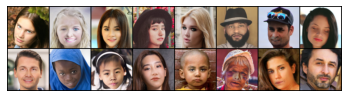

[0 1 1 1 0 1 1 0]


In [ ]:
vis_dataloader = DataLoader(trainset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

### **Building a CFFN**

In [ ]:
class SiameseNetwork(nn.Module):# A simple implementation of siamese network
    def __init__(self,model,n):#Parameters: The name of the model used and the size
        super(SiameseNetwork, self).__init__()
        self.cnn1 = model
        self.fc1 = nn.Linear(n, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 128)


    def forward(self, inputs):
        results = []

        for input in inputs:
            output = self.cnn1(input)
            output = output.view(output.size()[0], -1)
            output = F.relu(self.fc1(output))
            output = F.relu(self.fc2(output))
            output = self.fc3(output)

            results.append(output)

        return results

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch： 0  start.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch number 0
 Current loss 10259.893329108472

Epoch number 0
 Current loss 10289.107644708798

Epoch number 0
 Current loss 15215.956498462803

Epoch number 0
 Current loss 13718.173994161962

Epoch number 0
 Current loss 11769.94604241757

Epoch number 0
 Current loss 11300.159581359545

Epoch number 0
 Current loss 11283.677372127666

Epoch number 0
 Current loss 10731.559327317638

Epoch number 0
 Current loss 12696.367155068736

Epoch number 0
 Current loss 8314.925860011457

Epoch number 0
 Current loss 9370.804141539742

Epoch number 0
 Current loss 13722.840388903418

Epoch number 0
 Current loss 12245.964763696922

Epoch number 0
 Current loss 9829.00922858711

Epoch number 0
 Current loss 14724.775739349545

Epoch number 0
 Current loss 4419.325715198553

Accuracy of the network on the 1000 : 0 %


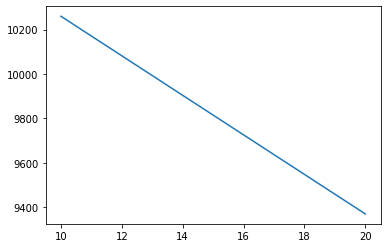

In [ ]:
# custom_cnn =  nn.Sequential(
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(3, BATCH_SIZE, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(BATCH_SIZE),
#             nn.Dropout2d(p=.2),
            
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(BATCH_SIZE, BATCH_SIZE, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(BATCH_SIZE),
#             nn.Dropout2d(p=.2),

#             nn.ReflectionPad2d(1),
#             nn.Conv2d(BATCH_SIZE, 32, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(32),
#             nn.Dropout2d(p=.2),
#         )

# custom_cnn_n = 32*100*100

net = SiameseNetwork(models.resnet50(pretrained=True),1000).cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,NUMBER_EPOCHS):
    print("Epoch：", epoch, " start.")
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels, _ = data
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU
        #print("epoch：", epoch, "No." , i, "th inputs", img0.data.size(), "labels", labels.data.size())
        optimizer.zero_grad()#clear the calculated grad in previous batch
        outputs = net([img0,img1])
        loss = ContrastiveLoss(labels, outputs[0], outputs[1])
        loss.backward()
        optimizer.step()

        print("Iteration number {}\n Current loss {}\n".format(i,loss.item()))
        if i %10 == 0 :#show changes of loss value after each 10 batches
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())
    
    #test the network after finish each epoch, to have a brief training result.
    correct_val = 0
    total_val = 0
    with torch.no_grad():#essential for testing
        for data in valloader:
            img0, img1 , labels, _ = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net([img0,img1])
            _, predicted = torch.max(outputs[0].data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    print('Accuracy of the network on the', total_val,': %d %%' % (100 * correct_val / total_val))
    show_plot(counter,loss_history)

### **Building a Classification Network**

In [ ]:
class NeuralNet(nn.Module):
    
    def __init__(self, in_features=4, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features=128,
                             out_features=120)
        self.fc2 = nn.Linear(in_features=120, 
                             out_features=84)
        self.fc3 = nn.Linear(in_features=84,  
                             out_features=2)
        self.activation = nn.Softmax(dim=1)

        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        return self.activation(X)

Epoch： 0  start.
Epoch number 0
 Current loss 0.6931543350219727

Epoch number 0
 Current loss 0.6931827664375305

Epoch number 0
 Current loss 0.6931474804878235

Epoch number 0
 Current loss 0.6931574940681458

Epoch number 0
 Current loss 0.6931474804878235

Epoch number 0
 Current loss 0.6931976675987244

Epoch number 0
 Current loss 0.6931808590888977

Epoch number 0
 Current loss 0.6931797862052917

Epoch number 0
 Current loss 0.6931540369987488

Epoch number 0
 Current loss 0.6932023763656616

Epoch number 0
 Current loss 0.6931915879249573

Epoch number 0
 Current loss 0.6931549310684204

Epoch number 0
 Current loss 0.6931371688842773

Epoch number 0
 Current loss 0.6931474804878235

Epoch number 0
 Current loss 0.6931199431419373

Epoch number 0
 Current loss 0.693140983581543

Accuracy of the network on the 1000 : 27 %


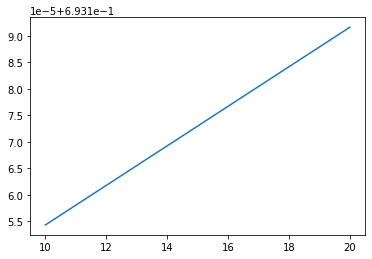

In [ ]:
net2 = NeuralNet().cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,NUMBER_EPOCHS):
    print("Epoch：", epoch, " start.")
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels, class_labels = data 
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU
        optimizer.zero_grad()#clear the calculated grad in previous batch
        outputs = net([img0,img1])
        out2 = net2(outputs[0])
        loss = criterion(out2, class_labels[0].cuda())

        loss.backward()
        optimizer.step()

        print("Iteration number {}\n Current loss {}\n".format(i,loss.item()))
        if i %10 == 0 :#show changes of loss value after each 10 batches
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())
    
    
    #test the network after finish each epoch, to have a brief training result.
    correct_val = 0
    total_val = 0
    with torch.no_grad():#essential for testing
        for data in valloader:
            img0, img1 , labels, class_labels = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net([img0,img1])
            out = net2(outputs[0])
            _, predicted = torch.max(out.data, 1)
            total_val += class_labels[0].cuda().size(0)
            correct_val += (predicted == class_labels[0].cuda()).sum().item()
            
    print('Accuracy of the network on the', total_val,': %d %%' % (100 * correct_val / total_val))
    show_plot(counter,loss_history)

In [ ]:
torch.save(net.state_dict(),"net.pth")
torch.save(net2.state_dict(),"net2.pth")

### **Streamlit GUI**

In [ ]:
#Writing all necessary functions in one cell
%%writefile DeepFakeGUI.py
import streamlit as st

from itertools import permutations, product
from random import sample, choice, shuffle
from glob import glob
import time
from datetime import timedelta
from tqdm import tqdm
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.models as models


class SiameseNetwork(nn.Module):# A simple implementation of siamese network, ResNet50 is used, and then connected by three fc layer.
    def __init__(self,model,n):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = model
        self.fc1 = nn.Linear(n, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 128)


    def forward(self, inputs):#did not know how to let two resnet share the same param.
        results = []

        for input in inputs:
            output = self.cnn1(input)
            output = output.view(output.size()[0], -1)
            output = F.relu(self.fc1(output))
            output = F.relu(self.fc2(output))
            output = self.fc3(output)

            results.append(output)

        return results


class NeuralNet(nn.Module):
    
    def __init__(self, in_features=4, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features=128,
                             out_features=120)
        self.fc2 = nn.Linear(in_features=120, 
                             out_features=84)
        self.fc3 = nn.Linear(in_features=84,  
                             out_features=2)
        self.activation = nn.Softmax(dim=1)

        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        return self.activation(X)


st.title("Deepfake Detection App")
st.subheader("This app takes in an image uploaded by the user and upon clicking the 'Verdict' button, displays if the uploaded image is fake or real" )

uploaded_file = st.file_uploader("Choose an image from your file directory", type=["jpg","png","jpeg"])
if uploaded_file is not None:
    image = Image.open(uploaded_file)

    net = SiameseNetwork(models.resnet50(pretrained=True),1000).cuda()
    net2 = NeuralNet().cuda()

    net.load_state_dict(torch.load("net.pth"))
    net2.load_state_dict(torch.load("net2.pth"))

    net.eval()
    net2.eval()

    st.image(image, caption='Uploaded Image.', use_column_width= True)
    st.write("")
    test_transforms = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.cuda()
    out1=net([input])
    output = net2(out1[0])
    print(output.data.cpu().numpy())
    prediction = output.data.cpu().numpy().argmax()

    if(st.button('Verdict')):
        if prediction == 0:
            st.error("The image uploaded is fake")
        elif prediction == 1:
            st.success("The image uploaded is real")

Overwriting DeepFakeGUI.py


In [ ]:
#Command to run the GUI
!streamlit run DeepFakeGUI.py & npx localtunnel --port 8501

npx: installed 22 in 1.418s
your url is: https://tender-turtle-63.loca.lt

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.234.14.117:8501

[[0.5 0.5]]
[[0.5 0.5]]
  Stopping...
^C
